Hard Drive Failure Prediction Masters Thesis
========================================
This notebook demonstrates a full pipeline for hard drive failure prediction using both LSTM (deep learning) and Decision Tree (CT) models.

You will:
- Train and test the LSTM model
- Train and test the Decision Tree model on raw data
- Generate LSTM predictions for all drives
- Test a random drive using the LSTM model
- Feed the LSTM results into the Decision Tree and analyze the outcome

**Requirements:**  
- All dependencies installed (see `requirements.txt`)
- Data available in `data`
- LSTM and CT code available in `notebooks/LSTM/smart.py` and `notebooks/CT/CT.py`

TODO: make sure the models are always saved in the correct folder on root/models

Index

1. [Thesis Overview](#thesis)
2. [Setup](#setup)
3. [Feature Selection & Correlation Analysis](#generate-a-correlation-matrix-to-see-the-best-features-to-use)
4. [Preprocessing Data](#preprocess-data)
5. [Missing Value Imputation](#missing-value-imputation)
6. [Categorical Variable Encoding](#categorical-variable-encoding)
7. [Ordinal Encoding of Capacity](#ordinal-encoding-of-capacity-capacity_bytes)
8. [Model Training and Evaluation](#step-2-load-the-data-to-train-the-models)
    - [LSTM Model](#step-3-train-the-lstm-model)
    - [Decision Tree Model](#step-4-train-and-test-the-decision-tree-ct-on-raw-data)
9. [Predictions and Visualization](#step-4-generate-predictions)
10. [Pipeline: LSTM + Decision Tree](#now-we-will-predict-a-hard-drive-with-the-lstm-and-consume-it-and-classify-the-prediction-result-with-the-ct)

In [1]:
# Step 1: Setup and Imports

import os
import sys
from typing import Optional
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import joblib
import json
from datetime import datetime
from sklearn.metrics import classification_report
import random
from joblib import load
import seaborn as sns
from feature_engine.imputation import RandomSampleImputer

# Add project root and submodules to sys.path for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, "notebooks/LSTM"))
sys.path.append(os.path.join(project_root, "notebooks/CT"))

import notebooks.LSTM.smart as smart
import notebooks.CT.CT as CT
from notebooks.LSTM.smart import Net


## Setup

Set the variables for the data paths and the features to be used in the models.

In [2]:
post_proc_data_path = "../data/"
ct_data_path = "../data/a_test/processed_data"
lstm_data_path = "../data/a_test/processed_data"
days_to_train = 4
days_to_predict = 1
verbose = True

# Correlation matrix parameters
n_features = 10 # Number of features to select based on correlation

#LSTM parameters
num_features = 10 # For default SMART data, this should match the number of features in your dataset
n_neurons = 6
num_epochs = 4000
learning_rate = 0.01

lstm_param_grid = {
    'n_neurons': [4, 8, 16, 32],
    'learning_rate': [0.001, 0.003, 0.005, 0.01],
    'batch_size': [2, 4, 8, 16]
}

#CT parameters
ct_depth = 100
ct_leaf = 15

ct_param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, None],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 40, 50]
}

In [3]:

# Set device for torch: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Feature Selection
Generate a correlation matrix to see the best features to use.

In [4]:
# Load data for correlation analysis
ct_raw_data = CT.importdata('../data/validation_data/', columns_to_delete=[])
preprocessing_df = ct_raw_data.copy()


Processing files in ../data/validation_data/data_Q1_2022: 100%|██████████| 90/90 [04:28<00:00,  2.98s/it]
Processing files in ../data/validation_data/data_Q2_2022: 100%|██████████| 91/91 [05:17<00:00,  3.49s/it]
Processing files in ../data/validation_data/data_Q3_2022: 100%|██████████| 92/92 [05:28<00:00,  3.58s/it]
Processing subfolders: 100%|██████████| 3/3 [15:14<00:00, 304.97s/it]

Dataset Length:  14538
Dataset Shape:  (14538, 179)
Dataset:                date serial_number                 model  capacity_bytes  \
63604   2022-01-01      WDH1BET6           ST4000DM005     -2122489856   
88320   2022-01-01     96BDP79NT    TOSHIBA MQ01ABF050      1891655680   
50226   2022-01-01      ZJV02ZZG         ST12000NM0007               0   
52542   2022-01-01  20H0A00SF97G   TOSHIBA MG07ACA14TA     -1073741824   
170427  2022-01-01      5PHLBVGF  HGST HUH721212ALE604               0   

        failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
63604      True                59.0  147088624.0                 0.0   
88320      True               100.0          0.0               100.0   
50226     False                83.0  215320520.0                 0.0   
52542     False               100.0          0.0               100.0   
170427    False               100.0          0.0               133.0   

        smart_2_raw  smart_3_normalized  ...  smart_250_norm

In [ ]:
ct_raw_data.drop(columns=['date','serial_number','model','capacity_bytes','datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format',], inplace=True, errors='ignore')

In [ ]:
ct_raw_data.drop(columns=[col for col in ct_raw_data.columns if col.startswith('smart_') and col.endswith('_raw')], inplace=True, errors='ignore')

In [ ]:
print("Columns in ct_raw_data:", ct_raw_data.columns.tolist())


Columns in ct_raw_data: ['failure', 'smart_1_normalized', 'smart_2_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized', 'smart_7_normalized', 'smart_8_normalized', 'smart_9_normalized', 'smart_10_normalized', 'smart_11_normalized', 'smart_12_normalized', 'smart_13_normalized', 'smart_15_normalized', 'smart_16_normalized', 'smart_17_normalized', 'smart_18_normalized', 'smart_22_normalized', 'smart_23_normalized', 'smart_24_normalized', 'smart_27_normalized', 'smart_71_normalized', 'smart_82_normalized', 'smart_90_normalized', 'smart_160_normalized', 'smart_161_normalized', 'smart_163_normalized', 'smart_164_normalized', 'smart_165_normalized', 'smart_166_normalized', 'smart_167_normalized', 'smart_168_normalized', 'smart_169_normalized', 'smart_170_normalized', 'smart_171_normalized', 'smart_172_normalized', 'smart_173_normalized', 'smart_174_normalized', 'smart_175_normalized', 'smart_176_normalized', 'smart_177_normalized', 'smart_178_normalized', 'smart_179_

In [ ]:
# Compute correlation matrix for all numeric columns
correlation_matrix = ct_raw_data.corr()

# Get absolute correlation with 'failure' and sort descending (excluding 'failure' itself)
feature_corr = correlation_matrix['failure'].abs().drop('failure').sort_values(ascending=False)

# Get all features with nonzero correlation to failure
best_features = feature_corr[feature_corr > 0].index.tolist()

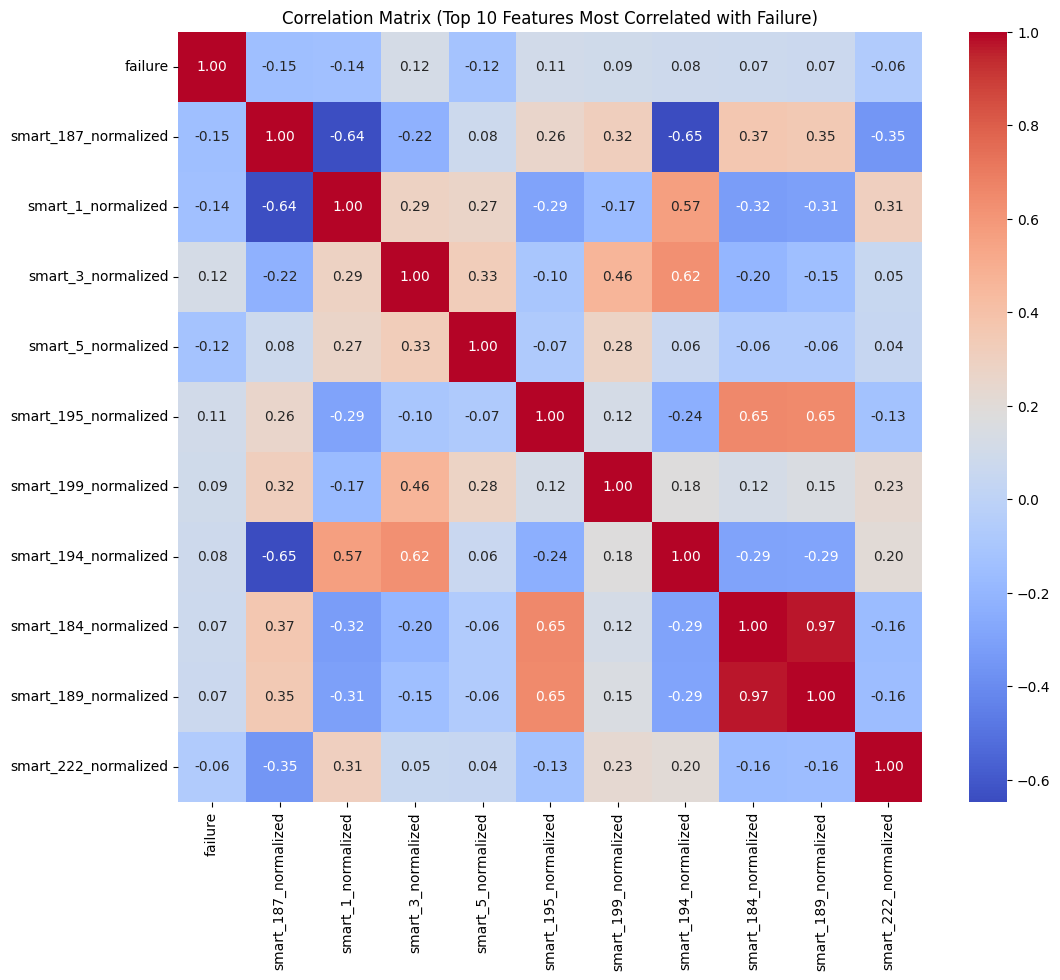

In [ ]:


# Plot the correlation matrix for the top 15 features most correlated with failure
top_n = 10
top_corr_features = feature_corr.head(top_n).index.tolist()
corr_subset = correlation_matrix.loc[['failure'] + top_corr_features, ['failure'] + top_corr_features]

plt.figure(figsize=(12, 10))
plt.title(f"Correlation Matrix (Top {top_n} Features Most Correlated with Failure)")
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [ ]:
# Print features and their correlation values
print("Best features by correlation with failure:")


for feature in best_features[:n_features]:
    print(f"{feature}: {feature_corr[feature]:.4f}")
normalized_rows = [int(feature.split('_')[1]) for feature in best_features[:n_features] if 'normalized' in feature]

Best features by correlation with failure:
smart_187_normalized: 0.1453
smart_1_normalized: 0.1413
smart_3_normalized: 0.1220
smart_5_normalized: 0.1215
smart_195_normalized: 0.1057
smart_199_normalized: 0.0935
smart_194_normalized: 0.0819
smart_184_normalized: 0.0745
smart_189_normalized: 0.0736
smart_222_normalized: 0.0623


In [ ]:
# We are only going to use normalized features for the LSTM model performance
print(f"Top {top_n} normalized features: ", normalized_rows)

# Changinge the number of features used based on correlation analysis results
num_features = len(normalized_rows)
print(f"Total number of features used: {num_features}")

Top 10 normalized features:  [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
Total number of features used: 10


## Preprocess data

In [6]:
columns_to_delete = [
    # Remove normalized and raw features in normalized_rows and raw_rows from columns_to_delete
    'datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format',
    'smart_1_normalized','smart_1_raw','smart_2_normalized','smart_2_raw','smart_3_normalized','smart_3_raw',
    'smart_4_normalized','smart_4_raw','smart_5_normalized','smart_5_raw','smart_7_normalized','smart_7_raw',
    'smart_8_normalized','smart_8_raw','smart_9_normalized','smart_9_raw','smart_10_normalized','smart_10_raw',
    'smart_11_normalized','smart_11_raw','smart_12_normalized','smart_12_raw','smart_13_normalized','smart_13_raw',
    'smart_15_normalized','smart_15_raw','smart_16_normalized','smart_16_raw','smart_17_normalized','smart_17_raw',
    'smart_18_normalized','smart_18_raw','smart_22_normalized','smart_22_raw','smart_23_normalized','smart_23_raw',
    'smart_24_normalized','smart_24_raw','smart_160_normalized','smart_160_raw','smart_161_normalized','smart_161_raw',
    'smart_163_normalized','smart_163_raw','smart_164_normalized','smart_164_raw','smart_165_normalized','smart_165_raw',
    'smart_166_normalized','smart_166_raw','smart_167_normalized','smart_167_raw','smart_168_normalized','smart_168_raw',
    'smart_169_normalized','smart_169_raw','smart_170_normalized','smart_170_raw','smart_171_normalized','smart_171_raw',
    'smart_172_normalized','smart_172_raw','smart_173_normalized','smart_173_raw','smart_174_normalized','smart_174_raw',
    'smart_175_normalized','smart_175_raw','smart_176_normalized','smart_176_raw','smart_177_normalized','smart_177_raw',
    'smart_178_normalized','smart_178_raw','smart_179_normalized','smart_179_raw','smart_180_normalized','smart_180_raw',
    'smart_181_normalized','smart_181_raw','smart_182_normalized','smart_182_raw','smart_183_normalized','smart_183_raw',
    'smart_184_normalized','smart_184_raw','smart_187_normalized','smart_187_raw','smart_188_normalized','smart_188_raw',
    'smart_189_normalized','smart_189_raw','smart_190_normalized','smart_190_raw','smart_191_normalized','smart_191_raw',
    'smart_192_normalized','smart_192_raw','smart_193_normalized','smart_193_raw','smart_194_normalized','smart_194_raw',
    'smart_195_normalized','smart_195_raw','smart_196_normalized','smart_196_raw','smart_197_normalized','smart_197_raw',
    'smart_198_normalized','smart_198_raw','smart_199_normalized','smart_199_raw','smart_200_normalized','smart_200_raw',
    'smart_201_normalized','smart_201_raw','smart_202_normalized','smart_202_raw','smart_206_normalized','smart_206_raw',
    'smart_210_normalized','smart_210_raw','smart_218_normalized','smart_218_raw','smart_220_normalized','smart_220_raw',
    'smart_222_normalized','smart_222_raw','smart_223_normalized','smart_223_raw','smart_224_normalized','smart_224_raw',
    'smart_225_normalized','smart_225_raw','smart_226_normalized','smart_226_raw','smart_230_normalized','smart_230_raw',
    'smart_231_normalized','smart_231_raw','smart_232_normalized','smart_232_raw','smart_233_normalized','smart_233_raw',
    'smart_234_normalized','smart_234_raw','smart_235_normalized','smart_235_raw','smart_240_normalized','smart_240_raw',
    'smart_241_normalized','smart_241_raw','smart_242_normalized','smart_242_raw','smart_244_normalized','smart_244_raw',
    'smart_245_normalized','smart_245_raw','smart_246_normalized','smart_246_raw','smart_247_normalized','smart_247_raw',
    'smart_248_normalized','smart_248_raw','smart_250_normalized','smart_250_raw','smart_251_normalized','smart_251_raw',
    'smart_252_normalized','smart_252_raw','smart_254_normalized','smart_254_raw','smart_255_normalized','smart_255_raw'
]


In [7]:


try:
    for n in normalized_rows:
        columns_to_delete.remove(f"smart_{n}_normalized")
except Exception as e:
    normalized_rows = [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
    for n in normalized_rows:
        columns_to_delete.remove(f"smart_{n}_normalized")
raw_rows = []
df = preprocessing_df.drop(columns=columns_to_delete, errors='ignore')

In [8]:
df

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_184_normalized,smart_187_normalized,smart_189_normalized,smart_194_normalized,smart_195_normalized,smart_199_normalized,smart_222_normalized
63604,2022-01-01,WDH1BET6,ST4000DM005,-2122489856,True,59.0,94.0,98.0,100.0,49.0,100.0,34.0,0.0,200.0,0.0
88320,2022-01-01,96BDP79NT,TOSHIBA MQ01ABF050,1891655680,True,100.0,100.0,100.0,0.0,0.0,0.0,100.0,0.0,200.0,1.0
50226,2022-01-01,ZJV02ZZG,ST12000NM0007,0,False,83.0,99.0,100.0,0.0,100.0,0.0,39.0,83.0,200.0,0.0
52542,2022-01-01,20H0A00SF97G,TOSHIBA MG07ACA14TA,-1073741824,False,100.0,100.0,100.0,0.0,0.0,0.0,100.0,0.0,200.0,70.0
170427,2022-01-01,5PHLBVGF,HGST HUH721212ALE604,0,False,100.0,100.0,100.0,0.0,0.0,0.0,181.0,0.0,200.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25659,2022-09-29,PL2331LAHDHWWJ,HGST HMS5C4040BLE640,-2122489856,False,100.0,100.0,100.0,0.0,0.0,0.0,240.0,0.0,200.0,0.0
168234,2022-09-29,ZLW15TMX,ST14000NM001G,-1073741824,True,82.0,94.0,100.0,0.0,78.0,0.0,37.0,0.0,200.0,0.0
229069,2022-09-29,ZL2K4LPC,ST16000NM001G,-1,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92823,2022-09-29,ZL2D9NCZ,ST14000NM001G,-1073741824,False,81.0,98.0,100.0,0.0,100.0,0.0,36.0,0.0,200.0,0.0


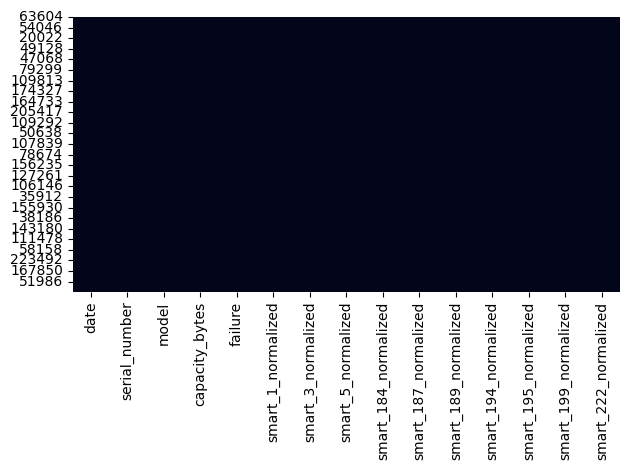

In [9]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
# plt.savefig(f'../reports/figures/heat_maps/heat_map_.png')
plt.close()

Now we will remove columns that only contain missing data.

In [10]:
nan_columns = df.columns[df.isna().all()].tolist()
print(f"Columns with only NaN values: {nan_columns}")

df = df.drop(columns=nan_columns)

Columns with only NaN values: []


We print the columns and the most frequently occurring elements to get an idea of what we will do with the different data.

In [11]:
for column in df.columns:
    print(f"Column: {column}")
    print(f"Top 3 most occurring elements: {df[column].value_counts().head(3).to_dict().keys()}")
    print(f"Number of NaN values: {df[column].isna().sum()}")
    print("\n")

Column: date
Top 3 most occurring elements: dict_keys(['2022-07-13', '2022-05-16', '2022-05-06'])
Number of NaN values: 0


Column: serial_number
Top 3 most occurring elements: dict_keys(['ZLW0WJA2', 'ZL23XZS4', '5PHLEMXD'])
Number of NaN values: 0


Column: model
Top 3 most occurring elements: dict_keys(['TOSHIBA MG07ACA14TA', 'ST4000DM000', 'ST12000NM0008'])
Number of NaN values: 0


Column: capacity_bytes
Top 3 most occurring elements: dict_keys([0, -1073741824, -2122489856])
Number of NaN values: 0


Column: failure
Top 3 most occurring elements: dict_keys([False, True])
Number of NaN values: 0


Column: smart_1_normalized
Top 3 most occurring elements: dict_keys([100.0, 83.0, 82.0])
Number of NaN values: 0


Column: smart_3_normalized
Top 3 most occurring elements: dict_keys([100.0, 92.0, 91.0])
Number of NaN values: 0


Column: smart_5_normalized
Top 3 most occurring elements: dict_keys([100.0, 0.0, 99.0])
Number of NaN values: 0


Column: smart_184_normalized
Top 3 most occurrin

We can see that columns with categorical variables have no missing variables. We will only work on replacing missing data with numerical variables that belong to S.M.A.R.T attributes, both normalized and raw.

In [12]:
for column in df.columns:
    nan_count = df[column].isna().sum()
    if nan_count > 0:
        print(f"Column: {column}, NaN values: {nan_count}")

### Missing Value Imputation
----------
Mode is used to impute qualitative predictors (categorical variables), and the mean or median is used to impute quantitative predictors (numerical variables).


### Categorical variables

Categorical variables with NaN elements in the dataset: none

In [13]:
nan_counts = df.iloc[:, :5].isna().sum()
print(nan_counts)

date              0
serial_number     0
model             0
capacity_bytes    0
failure           0
dtype: int64


### Numerical variables
We evaluate the distribution:

In a uniform distribution, the method to be used should be random substitution; on the other hand, if the distribution is similar to normal, i.e., symmetric and kurtosis greater than -1.0, if the variable shows outliers, median substitution is applied, since this measure of central tendency does not vary in the presence of such values; otherwise, arithmetic mean substitution is used.

In [14]:
output_dir = '../reports/figures/histogramas/'
os.makedirs(output_dir, exist_ok=True)

# Crear histogramas para las columnas 6 en adelante
for column in df.columns[5:]:
    plt.figure(figsize=(10, 6))
    df[column].dropna().hist(bins=50)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.savefig(f'{output_dir}{column}_histograma.png')
    plt.close()

Random substitution (Kurtosis less than -1.0 and uniform distribution)

Columnas con kurtosis menor a -1.0: ['smart_187_normalized']


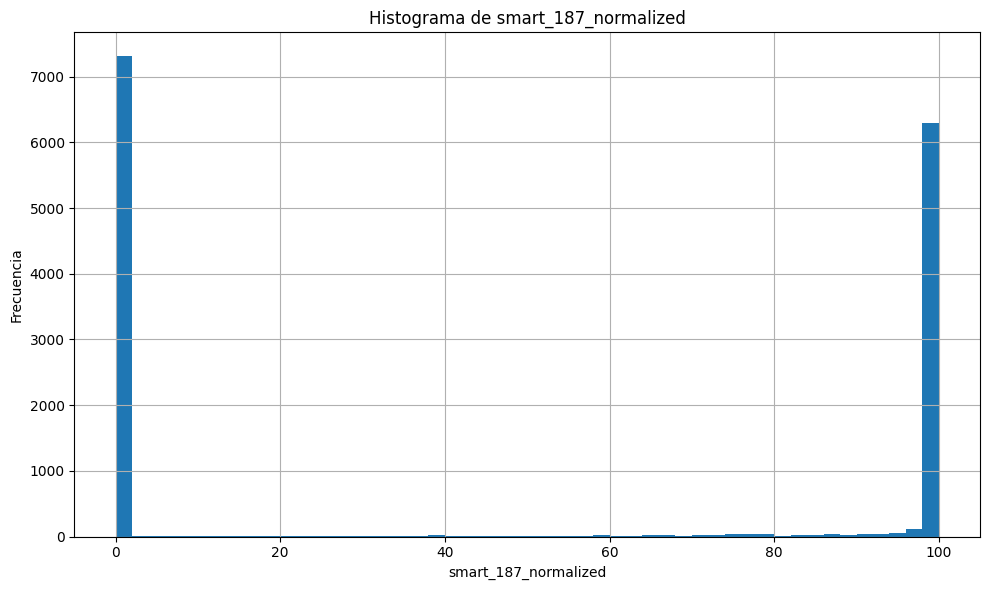

In [15]:
df_smart = df.iloc[:, 5:]
kurtosis_columns = [col for col in df_smart.columns if df_smart[col].kurtosis() < -1.0]
print(f"Columnas con kurtosis menor a -1.0: {kurtosis_columns}")
# Plot the column with kurtosis less than -1.0
for col in kurtosis_columns:
    plt.figure(figsize=(10, 6))
    df[col].dropna().hist(bins=50)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.savefig(f'../reports/figures/histogramas/{col}_histograma.png')
    plt.tight_layout()
    plt.show()
    plt.close()


### Search for outliers

With the IQR we see which columns have anomalies and save them in a dictionary

In [16]:
# Calcular el rango intercuartílico (IQR) para las columnas 6 en adelante
iqr_values = {}
outliers_dict = {}
no_kurtosis_df = df.drop(columns=kurtosis_columns)
for column in no_kurtosis_df.columns[5:]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    iqr_values[column] = IQR
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    print(f"Outliers in column {column}: {outliers.shape[0]}")
    if not outliers.empty:
        outliers_dict[column] = outliers

Outliers in column smart_1_normalized: 134
Outliers in column smart_3_normalized: 1213
Outliers in column smart_5_normalized: 756
Outliers in column smart_184_normalized: 3444
Outliers in column smart_189_normalized: 3410
Outliers in column smart_194_normalized: 1160
Outliers in column smart_195_normalized: 3601
Outliers in column smart_199_normalized: 932
Outliers in column smart_222_normalized: 3018


We create the dictionary to substitute null values

In [17]:
valores = {}
for column in df.columns[5:]:
    if column not in kurtosis_columns:
        if column in outliers:
            valores[column] = df[column].median()
        else:
            valores[column] = df[column].mean()

print(valores)

{'smart_1_normalized': np.float64(100.0), 'smart_3_normalized': np.float64(97.0), 'smart_5_normalized': np.float64(100.0), 'smart_184_normalized': np.float64(0.0), 'smart_189_normalized': np.float64(0.0), 'smart_194_normalized': np.float64(42.0), 'smart_195_normalized': np.float64(0.0), 'smart_199_normalized': np.float64(200.0), 'smart_222_normalized': np.float64(0.0)}


In [18]:
df=df.fillna(valores)
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 0


In [19]:
aleatorio=RandomSampleImputer()
for column in kurtosis_columns:
    df[column]=aleatorio.fit_transform(df[[column]])
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 0


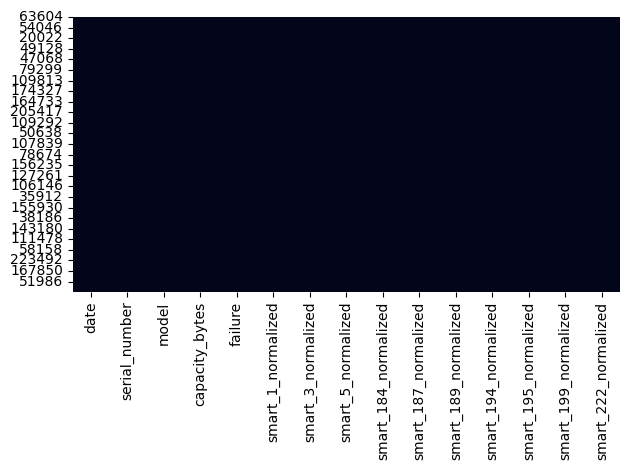

In [20]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
plt.close()

### Categorical Variable Encoding
-------------
[Categorical Variable Encoding](../references/codificacion_var_categoricas.pdf)

Variables that we will convert to a categorical variable:
- model: Will be divided into two variables: Company and model.
- capacity_bytes: We will separate them into different categories depending on the amount of storage


In [21]:
# Calcular la frecuencia de cada modelo
model_freq = df['model'].value_counts()

# Crear un diccionario para mapear cada modelo a su frecuencia
model_freq_dict = model_freq.to_dict()

# Crear una nueva columna categórica basada en la frecuencia de uso
df['model_freq'] = df['model'].map(model_freq_dict)

# Convertir la nueva columna a tipo categórico
df['model_freq'] = pd.cut(df['model_freq'], bins=[0, 10, 100, 1000, 10000, float('inf')],
                          labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])

print(df[['model', 'model_freq']].head())

                       model model_freq
63604            ST4000DM005   Muy Bajo
88320     TOSHIBA MQ01ABF050       Bajo
50226          ST12000NM0007      Medio
52542    TOSHIBA MG07ACA14TA       Alto
170427  HGST HUH721212ALE604      Medio


They are divided into brand and model

In [22]:
import re

def extract_brand(model):
    match = re.match(r'^[A-Za-z]+', model)
    return match.group(0) if match else None

df['brand'] = df['model'].apply(extract_brand)
print(df['brand'].drop_duplicates())

63604           ST
88320      TOSHIBA
170427        HGST
202305     Seagate
195813         WDC
161966    DELLBOSS
96306           CT
8746       MTFDDAV
18768      Hitachi
Name: brand, dtype: object


In [23]:
print(df.head())

              date serial_number                 model  capacity_bytes  \
63604   2022-01-01      WDH1BET6           ST4000DM005     -2122489856   
88320   2022-01-01     96BDP79NT    TOSHIBA MQ01ABF050      1891655680   
50226   2022-01-01      ZJV02ZZG         ST12000NM0007               0   
52542   2022-01-01  20H0A00SF97G   TOSHIBA MG07ACA14TA     -1073741824   
170427  2022-01-01      5PHLBVGF  HGST HUH721212ALE604               0   

        failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
63604      True                59.0                94.0                98.0   
88320      True               100.0               100.0               100.0   
50226     False                83.0                99.0               100.0   
52542     False               100.0               100.0               100.0   
170427    False               100.0               100.0               100.0   

        smart_184_normalized  smart_187_normalized  smart_189_normalized  \
6360

Now we apply One-Hot encoding to the brand and model frequency

In [24]:
df = pd.get_dummies(df, columns=['brand', 'model_freq'])
print(df.head())

              date serial_number                 model  capacity_bytes  \
63604   2022-01-01      WDH1BET6           ST4000DM005     -2122489856   
88320   2022-01-01     96BDP79NT    TOSHIBA MQ01ABF050      1891655680   
50226   2022-01-01      ZJV02ZZG         ST12000NM0007               0   
52542   2022-01-01  20H0A00SF97G   TOSHIBA MG07ACA14TA     -1073741824   
170427  2022-01-01      5PHLBVGF  HGST HUH721212ALE604               0   

        failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
63604      True                59.0                94.0                98.0   
88320      True               100.0               100.0               100.0   
50226     False                83.0                99.0               100.0   
52542     False               100.0               100.0               100.0   
170427    False               100.0               100.0               100.0   

        smart_184_normalized  smart_187_normalized  ...  brand_MTFDDAV  \
63604 

#### Converting capacity_bytes to ordinal categorical:

In [25]:
print(df['capacity_bytes'].unique())

[-2122489856  1891655680           0 -1073741824    39149568 -2147483648
   951246848  1105813504          -1  -999489536  -460759040        -512]


In [26]:
# Replace -1 in 'capacity_bytes' with the correct value from the same serial_number

# First, find serial_numbers with more than one unique capacity (including -1)
mask_minus1 = df['capacity_bytes'] == '-1'
serials_with_minus1 = df.loc[mask_minus1, 'serial_number'].unique()

# For each affected serial_number, replace -1 with the other value
for serial in tqdm(serials_with_minus1, desc="Replacing -1 in capacity_bytes"):
    # Get all unique non -1 capacities for this serial_number
    capacities = df.loc[(df['serial_number'] == serial) & (df['capacity_bytes'] != '-1'), 'capacity_bytes'].unique()
    if len(capacities) == 1:
        correct_capacity = capacities[0]
        df.loc[(df['serial_number'] == serial) & (df['capacity_bytes'] == '-1'), 'capacity_bytes'] = correct_capacity

print("Replaced -1 values in 'capacity_bytes' where possible.")

Replacing -1 in capacity_bytes: 0it [00:00, ?it/s]

Replaced -1 values in 'capacity_bytes' where possible.


In [27]:
print(df['capacity_bytes'].unique())

[-2122489856  1891655680           0 -1073741824    39149568 -2147483648
   951246848  1105813504          -1  -999489536  -460759040        -512]


In [28]:
Var=df['capacity_bytes']                      # Variable categórica ordinal
n=Var.nunique()                     # Cardinalidad
lim_inf=(n-1)//2 if n%2!=0 else n-1 # Abs del límite inferior
step=1 if n%2!=0 else 2             # Intervalo
X=range(-lim_inf,lim_inf+1,step)
list(X)

[-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11]

In [29]:
beta0=0
beta1=1 # beta1>0  ->  codificación creciente. beta1<0  ->  codificación decreciente
y=[beta0+beta1*x for x in X]
y

[-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11]

In [30]:
# Asociamos estos valores a las categorías ordenadas de 'Var'
# Var.unique()
Var_ord = np.sort(Var.unique())
Var_ord

array([-2147483648, -2122489856, -1073741824,  -999489536,  -460759040,
              -512,          -1,           0,    39149568,   951246848,
        1105813504,  1891655680], dtype=int32)

In [31]:
map_lin_CB={categoria:codificacion for categoria,codificacion in zip(Var_ord,y)}
map_lin_CB

{np.int32(-2147483648): -11,
 np.int32(-2122489856): -9,
 np.int32(-1073741824): -7,
 np.int32(-999489536): -5,
 np.int32(-460759040): -3,
 np.int32(-512): -1,
 np.int32(-1): 1,
 np.int32(0): 3,
 np.int32(39149568): 5,
 np.int32(951246848): 7,
 np.int32(1105813504): 9,
 np.int32(1891655680): 11}

In [32]:
df['Lin_capacity_bytes']=df['capacity_bytes'].map(map_lin_CB)

df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_184_normalized,smart_187_normalized,...,brand_ST,brand_Seagate,brand_TOSHIBA,brand_WDC,model_freq_Muy Bajo,model_freq_Bajo,model_freq_Medio,model_freq_Alto,model_freq_Muy Alto,Lin_capacity_bytes
63604,2022-01-01,WDH1BET6,ST4000DM005,-2122489856,True,59.0,94.0,98.0,100.0,49.0,...,True,False,False,False,True,False,False,False,False,-9
88320,2022-01-01,96BDP79NT,TOSHIBA MQ01ABF050,1891655680,True,100.0,100.0,100.0,0.0,0.0,...,False,False,True,False,False,True,False,False,False,11
50226,2022-01-01,ZJV02ZZG,ST12000NM0007,0,False,83.0,99.0,100.0,0.0,100.0,...,True,False,False,False,False,False,True,False,False,3
52542,2022-01-01,20H0A00SF97G,TOSHIBA MG07ACA14TA,-1073741824,False,100.0,100.0,100.0,0.0,0.0,...,False,False,True,False,False,False,False,True,False,-7
170427,2022-01-01,5PHLBVGF,HGST HUH721212ALE604,0,False,100.0,100.0,100.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,3


### Store the processed data

In [33]:
import shutil

# Store each day's data in a separate CSV file in ../data/processed_data
#output_dir = "../data/a_test/processed_data"
output_dir = "../data/validation_data/processed_data"

# Delete all contents of the output directory before storing new files
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])
# Group by date and save each group to a separate CSV, overwriting if file exists
for day, group in df.groupby(df['date'].dt.date):
    filename = os.path.join(output_dir, f"data_{day}.csv")
    group.to_csv(filename, index=False, mode='w')  # mode='w' ensures overwrite
    print(f"Saved (overwritten) {filename}")


Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-01.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-02.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-03.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-04.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-05.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-06.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-07.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-08.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-09.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-10.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-11.csv
Saved (overwritten) ../data/validation_data/processed_data\data_2022-01-12.csv
Saved (overwritten) ../data/validation_data/processe

## LSTM

In [34]:
# dtype_dictionary = {
#     # Core identification and metadata columns
#     'date': 'str',                          # Will be converted to datetime later
#     'serial_number': 'str',                 # Drive identifier
#     'model': 'str',                         # Hard drive model
#     'capacity_bytes': 'str',                # Keep as string due to potential '-1' values
#     'failure': 'bool',                      # Target variable (binary)
    
#     # SMART normalized attributes (0-1 range typically)
#     'smart_1_normalized': 'float32',        # Read Error Rate
#     'smart_3_normalized': 'float32',        # Spin Up Time
#     'smart_5_normalized': 'float32',        # Reallocated Sectors Count
#     'smart_187_normalized': 'float32',      # Reported Uncorrectable Errors
#     'smart_195_normalized': 'float32',      # Hardware ECC Recovered
    
#     # SMART raw attributes (can be large integers)
#     'smart_5_raw': 'int64',                 # Reallocated Sectors Count (raw)
#     'smart_9_raw': 'int64',                 # Power-On Hours (raw)
    
#     # Brand columns (one-hot encoded - binary) - These are the actual brands in your data
#     'brand_HGST': 'bool',
#     'brand_Hitachi': 'bool',
#     'brand_SAMSUNG': 'bool',
#     'brand_ST': 'bool',
#     'brand_Seagate': 'bool',
#     'brand_TOSHIBA': 'bool',
#     'brand_WD': 'bool',
#     'brand_WDC': 'bool',
#     'brand_WUH': 'bool',
    
#     # Model frequency columns (one-hot encoded - binary) - Spanish labels from your preprocessing
#     'model_freq_Muy Bajo': 'bool',          # Very Low frequency
#     'model_freq_Bajo': 'bool',              # Low frequency
#     'model_freq_Medio': 'bool',             # Medium frequency
#     'model_freq_Alto': 'bool',              # High frequency
#     'model_freq_Muy Alto': 'bool',          # Very High frequency
    
#     # Ordinal encoded capacity (your mapping creates small integer values)
#     'Lin_capacity_bytes': 'int8',           # Small ordinal values from your mapping
# }

columns_to_delete = ['model', 'capacity_bytes', 'brand_HGST', 'brand_Hitachi', 'brand_SAMSUNG', 'brand_ST', 'brand_Seagate',
    'brand_TOSHIBA', 'brand_WD', 'brand_WDC', 'brand_WUH',
    'model_freq_Muy Bajo', 'model_freq_Bajo', 'model_freq_Medio',
    'model_freq_Alto', 'model_freq_Muy Alto',
    'Lin_capacity_bytes']

In [35]:
min_sequence_length = days_to_train + days_to_predict
print(f'Using device: {device}')


Using device: cuda


In [36]:
try:
    print(f"normalized_rows: {normalized_rows}")
    print(f"Expected features: {len(normalized_rows)}")
except Exception as e:
    print(f"Exception: {e}, defining normalized_rows...")
    normalized_rows = [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
print(f"normalized_rows: {normalized_rows}")
print(f"Expected features: {len(normalized_rows)}")
raw_rows = []

normalized_rows: [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
Expected features: 10
normalized_rows: [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
Expected features: 10


In [37]:

print("🔄 Loading and splitting data to prevent data leakage...")

train_loader, test_loader = smart.load_data(root=lstm_data_path,
                                        train_ratio=0.8, 
                                        min_sequence_length=min_sequence_length,
                                        input_len=days_to_train,
                                        label_len=days_to_predict,
                                        normalized_rows=normalized_rows,
                                        raw_rows=raw_rows,
                                        verbose=False,
                                        batch_size=3,
                                        columns_to_delete=columns_to_delete)


🔄 Loading and splitting data to prevent data leakage...


Loading CSV files: 100%|██████████| 361/361 [00:12<00:00, 28.35it/s]


[DriveDataLoader] Columns in data: ['date', 'serial_number', 'failure', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_184_normalized', 'smart_187_normalized', 'smart_189_normalized', 'smart_194_normalized', 'smart_195_normalized', 'smart_199_normalized', 'smart_222_normalized']


### Train the LSTM model

In [38]:
# Check if trained model exists
model_path = '../models/LSTM/lstm_model.pth'
print(f" n_neurons: {n_neurons}, model_path: {model_path}, days_to_predict: {days_to_predict}, days_to_train: {days_to_train}, train_loader: {train_loader}, test_loader: {test_loader}, learning_rate: {learning_rate}, num_epochs: {num_epochs}")
model, model_exists = smart.train_model(features = num_features,
            n_neurons = n_neurons,
            model_path = model_path,
            days_to_predict = days_to_predict,
            days_to_train = days_to_train,
            train_loader = train_loader,
            test_loader = test_loader,
            test_existing = False,
            learning_rate = learning_rate,
            num_epochs = num_epochs)


 n_neurons: 6, model_path: ../models/LSTM/lstm_model.pth, days_to_predict: 1, days_to_train: 4, train_loader: <torch.utils.data.dataloader.DataLoader object at 0x0000017C6A663730>, test_loader: <torch.utils.data.dataloader.DataLoader object at 0x0000017C6A663160>, learning_rate: 0.01, num_epochs: 4000
shape: (torch.Size([3, 4, 10]), torch.Size([3, 1, 10]))
No saved model found. Training from scratch...


Training Progress:  10%|▉         | 399/4000 [00:24<03:21, 17.87it/s]

[400/4000] - Train Loss: 5564.016079, Val Loss: 5153.594755


Training Progress:  16%|█▌        | 623/4000 [00:37<03:24, 16.51it/s]


KeyboardInterrupt: 

### Generate predictions 

In [ ]:
# Generate predictions on test set
model.eval()
test_predictions = []
test_targets = []

print("Generating final predictions...")
with torch.no_grad():
    for test_data, test_labels in tqdm(test_loader, desc="Generating predictions"):
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        predictions = model(test_data)
        test_predictions.append(predictions.cpu().numpy())
        test_targets.append(test_labels.cpu().numpy())

# Concatenate all predictions and targets
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

Generating final predictions...


Generating predictions: 100%|██████████| 2/2 [00:00<00:00, 249.98it/s]


### Plot the results

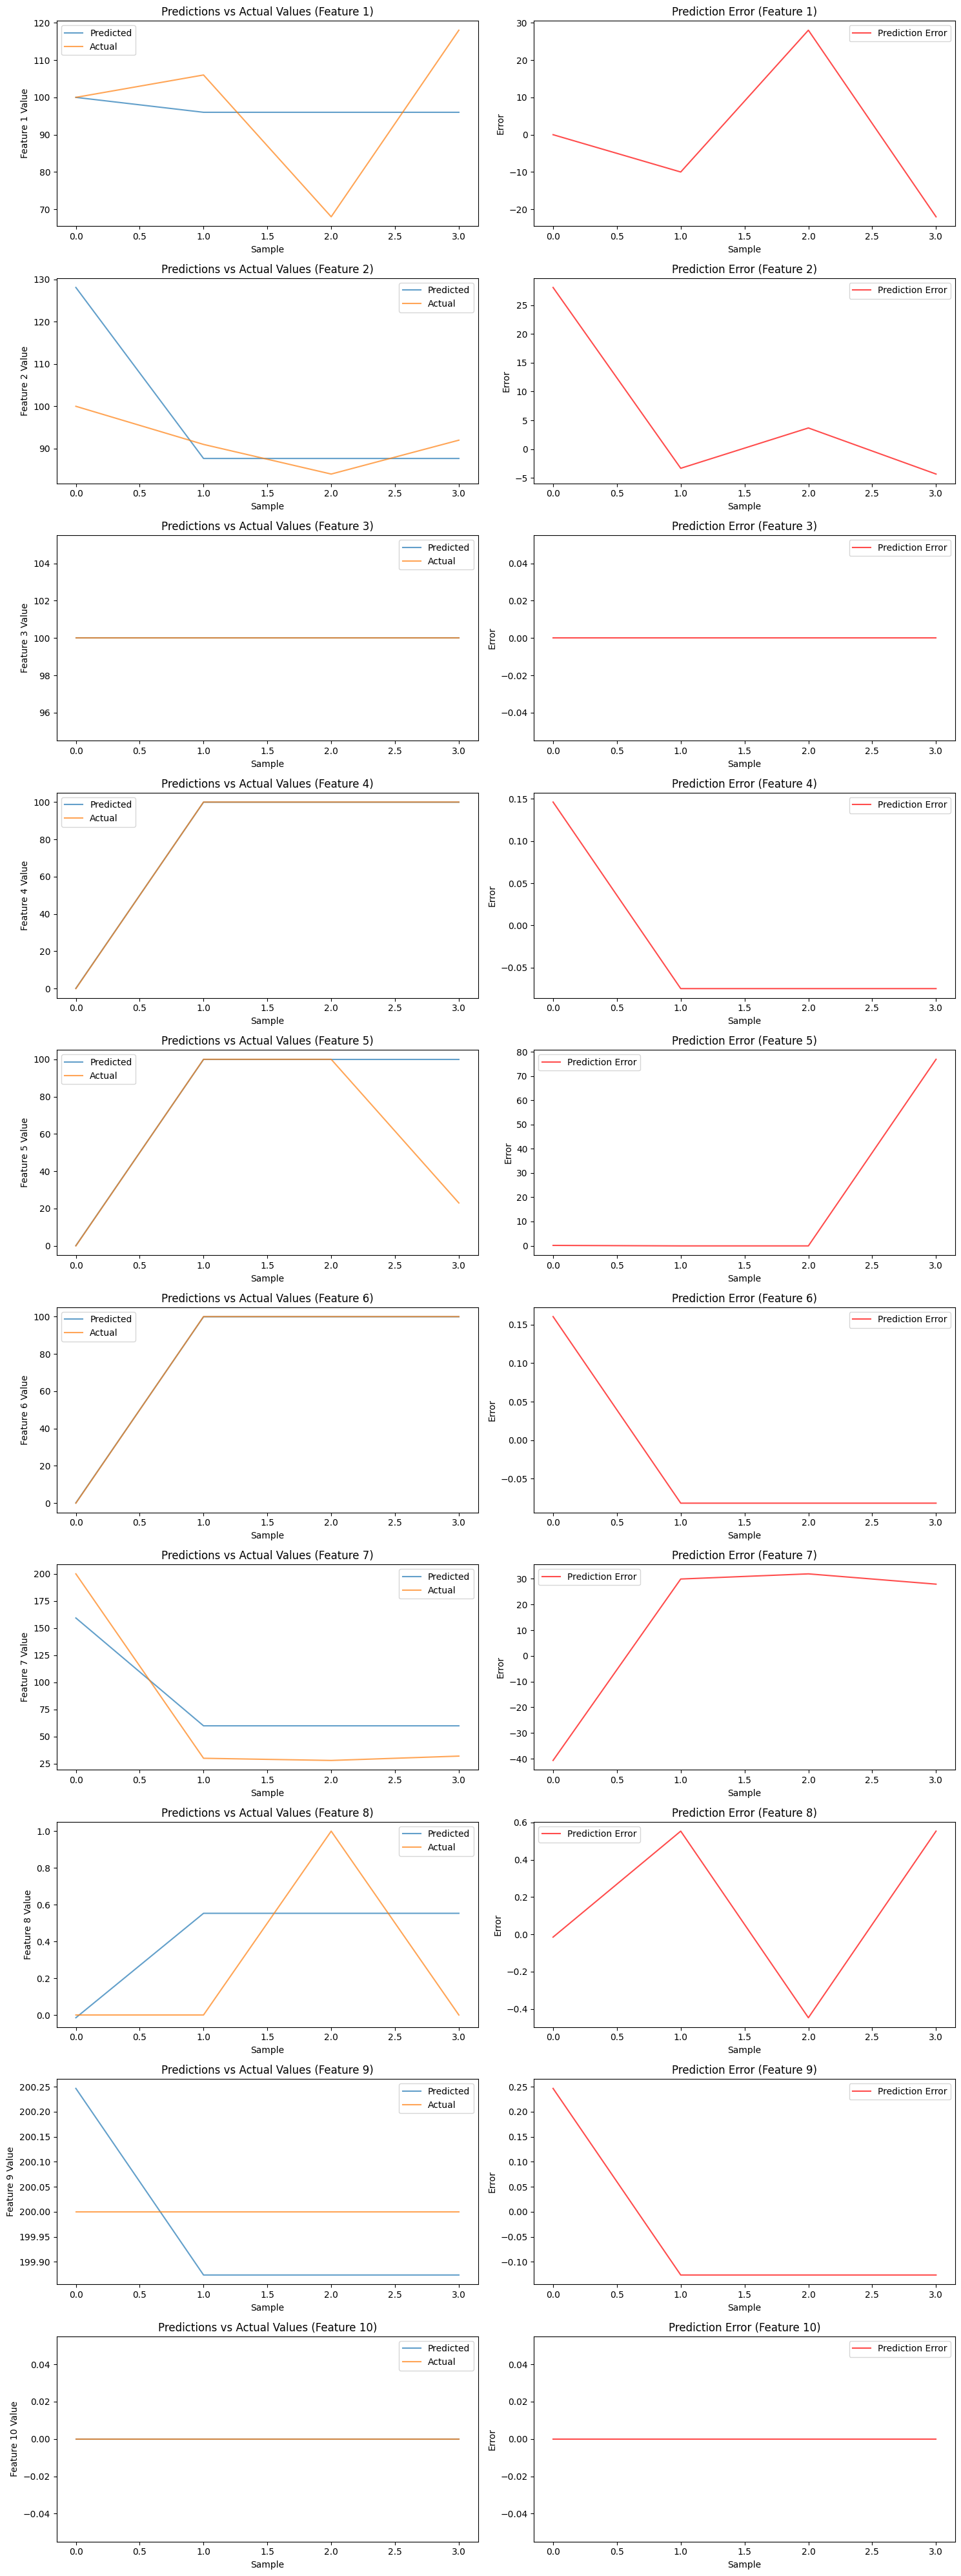

In [ ]:
# Plot predictions vs actual values for all features
num_features = test_predictions.shape[2]
num_samples_to_plot = min(50, len(test_predictions))
x = np.arange(num_samples_to_plot)

fig, axes = plt.subplots(num_features, 2, figsize=(15, 4 * num_features))

for i in range(num_features):
    # Predictions vs Actual
    axes[i, 0].plot(x, test_predictions[:num_samples_to_plot, 0, i], label='Predicted', alpha=0.7)
    axes[i, 0].plot(x, test_targets[:num_samples_to_plot, 0, i], label='Actual', alpha=0.7)
    axes[i, 0].set_xlabel("Sample")
    axes[i, 0].set_ylabel(f"Feature {i+1} Value")
    axes[i, 0].set_title(f"Predictions vs Actual Values (Feature {i+1})")
    axes[i, 0].legend()

    # Prediction Error
    error = test_predictions[:num_samples_to_plot, 0, i] - test_targets[:num_samples_to_plot, 0, i]
    axes[i, 1].plot(x, error, label='Prediction Error', color='red', alpha=0.7)
    axes[i, 1].set_xlabel("Sample")
    axes[i, 1].set_ylabel("Error")
    axes[i, 1].set_title(f"Prediction Error (Feature {i+1})")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

## Decision Tree Model
We will now train and test the Decision Tree model using the raw SMART data.

### Load the data to train the Decision Tree model

In [73]:
columns_to_delete += ['date', 'serial_number']

In [74]:
data = CT.importdata(ct_data_path, normalized_rows, raw_rows, columns_to_delete=columns_to_delete)


Processing CSV files:   0%|          | 0/361 [00:00<?, ?it/s]

Processing CSV files: 100%|██████████| 361/361 [00:08<00:00, 41.79it/s]

Dataset Length:  28518
Dataset Shape:  (28518, 12)
Dataset:      failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
0      True                82.0                84.0               100.0   
19     True                83.0                94.0               100.0   
53    False                80.0                90.0               100.0   
4     False                79.0                84.0               100.0   
55    False                72.0                91.0               100.0   

    smart_184_normalized  smart_187_normalized  smart_189_normalized  \
0                  100.0                 100.0                 100.0   
19                   0.0                  60.0                   0.0   
53                   0.0                 100.0                   0.0   
4                  100.0                 100.0                 100.0   
55                   0.0                 100.0                   0.0   

    smart_194_normalized  smart_195_normalized  smart_1

In [75]:

# Split dataset and apply SMOTE
X, Y, X_train_res, X_test, y_train_res, y_test = CT.splitdataset(data)

x_train (after SMOTE): [[100.         100.         100.         ... 200.          54.
    0.        ]
 [ 79.          90.         100.         ... 200.           0.
    0.        ]
 [100.          83.         100.         ... 100.           0.
    0.        ]
 ...
 [ 39.51964056  90.27996006  21.64047925 ... 200.           0.
    0.        ]
 [ 79.62055375  84.         100.         ... 200.           0.
    0.        ]
 [100.         163.98889394 100.         ... 200.           0.
    0.        ]]
y_train (after SMOTE): True 16624 33248


c:\Users\Green\miniconda3\envs\thesis\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [ ]:
# Grid search for best hyperparameters (Gini)
print("\nPerforming grid search for Decision Tree (Gini)...")
best_params, best_score = CT.grid_search_decision_tree(X_train_res, y_train_res)
depth = best_params['max_depth']
leaf = best_params['min_samples_leaf']


Performing grid search for Decision Tree (Gini)...
Best parameters from grid search: {'max_depth': 40, 'min_samples_leaf': 1}
Best cross-validated accuracy: 0.8134


### Train both decision tree models

In [139]:
depth = 5
leaf = 3

In [140]:
print("\nTraining Decision Tree with Gini criterion...")
clf_gini = CT.train_using_gini(X_train_res, X_test, y_train_res, depth=depth, leaf=leaf)


Training Decision Tree with Gini criterion...


In [141]:
print("\nTraining Decision Tree with Entropy criterion...")
clf_entropy = CT.train_using_entropy(X_train_res, X_test, y_train_res, depth=depth, leaf=leaf)


Training Decision Tree with Entropy criterion...


### Test models

In [142]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)


Results Using Gini Index:
Predicted values:
[ True  True False ... False  True False]


In [143]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)
gini_accuracy = CT.cal_accuracy(y_test, y_pred_gini, clf_gini, "gini", model_dir="../models/DT")


Results Using Gini Index:
Predicted values:
[ True  True False ... False  True False]
Confusion Matrix:  [[5815 1326]
 [ 413 1002]]
Accuracy :  79.67508181393174
Report :                precision    recall  f1-score   support

       False       0.93      0.81      0.87      7141
        True       0.43      0.71      0.54      1415

    accuracy                           0.80      8556
   macro avg       0.68      0.76      0.70      8556
weighted avg       0.85      0.80      0.81      8556

FP:  1326.0
FN:  413.0
TP:  1002.0
TN:  5815.0
TPR:  0.7081272084805653
TNR:  0.8143117210474723
PPV:  0.43041237113402064
NPV:  0.9336865767501605
FPR:  0.18568827895252765
FNR:  0.2918727915194346
FDR:  0.5695876288659794
ACC:  0.7967508181393175
❌ New gini model accuracy (0.7968) not better than previous best (0.8242)


In [144]:
print("\n" + "="*50)
print("Results Using Entropy:")
print("="*50)
y_pred_entropy = CT.prediction(X_test, clf_entropy)


Results Using Entropy:
Predicted values:
[ True  True False ... False  True False]


In [145]:
CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy", model_dir="../models/DT")

Confusion Matrix:  [[5821 1320]
 [ 415 1000]]
Accuracy :  79.72183263207107
Report :                precision    recall  f1-score   support

       False       0.93      0.82      0.87      7141
        True       0.43      0.71      0.54      1415

    accuracy                           0.80      8556
   macro avg       0.68      0.76      0.70      8556
weighted avg       0.85      0.80      0.81      8556

FP:  1320.0
FN:  415.0
TP:  1000.0
TN:  5821.0
TPR:  0.7067137809187279
TNR:  0.8151519395042711
PPV:  0.43103448275862066
NPV:  0.9334509300833868
FPR:  0.18484806049572888
FNR:  0.29328621908127206
FDR:  0.5689655172413793
ACC:  0.7972183263207107
❌ New entropy model accuracy (0.7972) not better than previous best (0.8241)


0.7972183263207107

### Save models

In [127]:
# Directory to store models
dt_model_dir = "../models/DT"
os.makedirs(dt_model_dir, exist_ok=True)

# Paths for Gini and Entropy models
gini_model_path = os.path.join(dt_model_dir, "dt_gini.joblib")
entropy_model_path = os.path.join(dt_model_dir, "dt_entropy.joblib")

# Helper function to load accuracy if model exists
def load_existing_accuracy(model_path):
    acc_path = model_path + ".acc"
    if os.path.exists(acc_path):
        with open(acc_path, "r") as f:
            return float(f.read().strip())
    return None

# Save model and accuracy
def save_model_and_accuracy(model, model_path, accuracy):
    joblib.dump(model, model_path)
    with open(model_path + ".acc", "w") as f:
        f.write(str(accuracy))

# Check and save Gini model if better
existing_gini_acc = load_existing_accuracy(gini_model_path)
if existing_gini_acc is None or gini_accuracy > existing_gini_acc:
    save_model_and_accuracy(clf_gini, gini_model_path, gini_accuracy)
    print(f"Saved improved Gini model with accuracy {gini_accuracy:.4f}")

# Check and save Entropy model if better
existing_entropy_acc = load_existing_accuracy(entropy_model_path)
entropy_accuracy = CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy")
if existing_entropy_acc is None or entropy_accuracy > existing_entropy_acc:
    save_model_and_accuracy(clf_entropy, entropy_model_path, entropy_accuracy)
    print(f"Saved improved Entropy model with accuracy {entropy_accuracy:.4f}")

Saved improved Gini model with accuracy 0.8070
Confusion Matrix:  [[5981 1160]
 [ 479  936]]
Accuracy :  80.84385226741469
Report :                precision    recall  f1-score   support

       False       0.93      0.84      0.88      7141
        True       0.45      0.66      0.53      1415

    accuracy                           0.81      8556
   macro avg       0.69      0.75      0.71      8556
weighted avg       0.85      0.81      0.82      8556

FP:  1160.0
FN:  479.0
TP:  936.0
TN:  5981.0
TPR:  0.6614840989399293
TNR:  0.8375577650189049
PPV:  0.44656488549618323
NPV:  0.9258513931888545
FPR:  0.16244223498109508
FNR:  0.3385159010600707
FDR:  0.5534351145038168
ACC:  0.8084385226741468
❌ New entropy model accuracy (0.8084) not better than previous best (0.8241)
Saved improved Entropy model with accuracy 0.8084


### Visualize the results

In [ ]:
smart_features = [f'smart_{i:03}' for i in range(1, 255)]

✅ Decision tree plot saved to ../reports/figures/decision_tree_gini.png


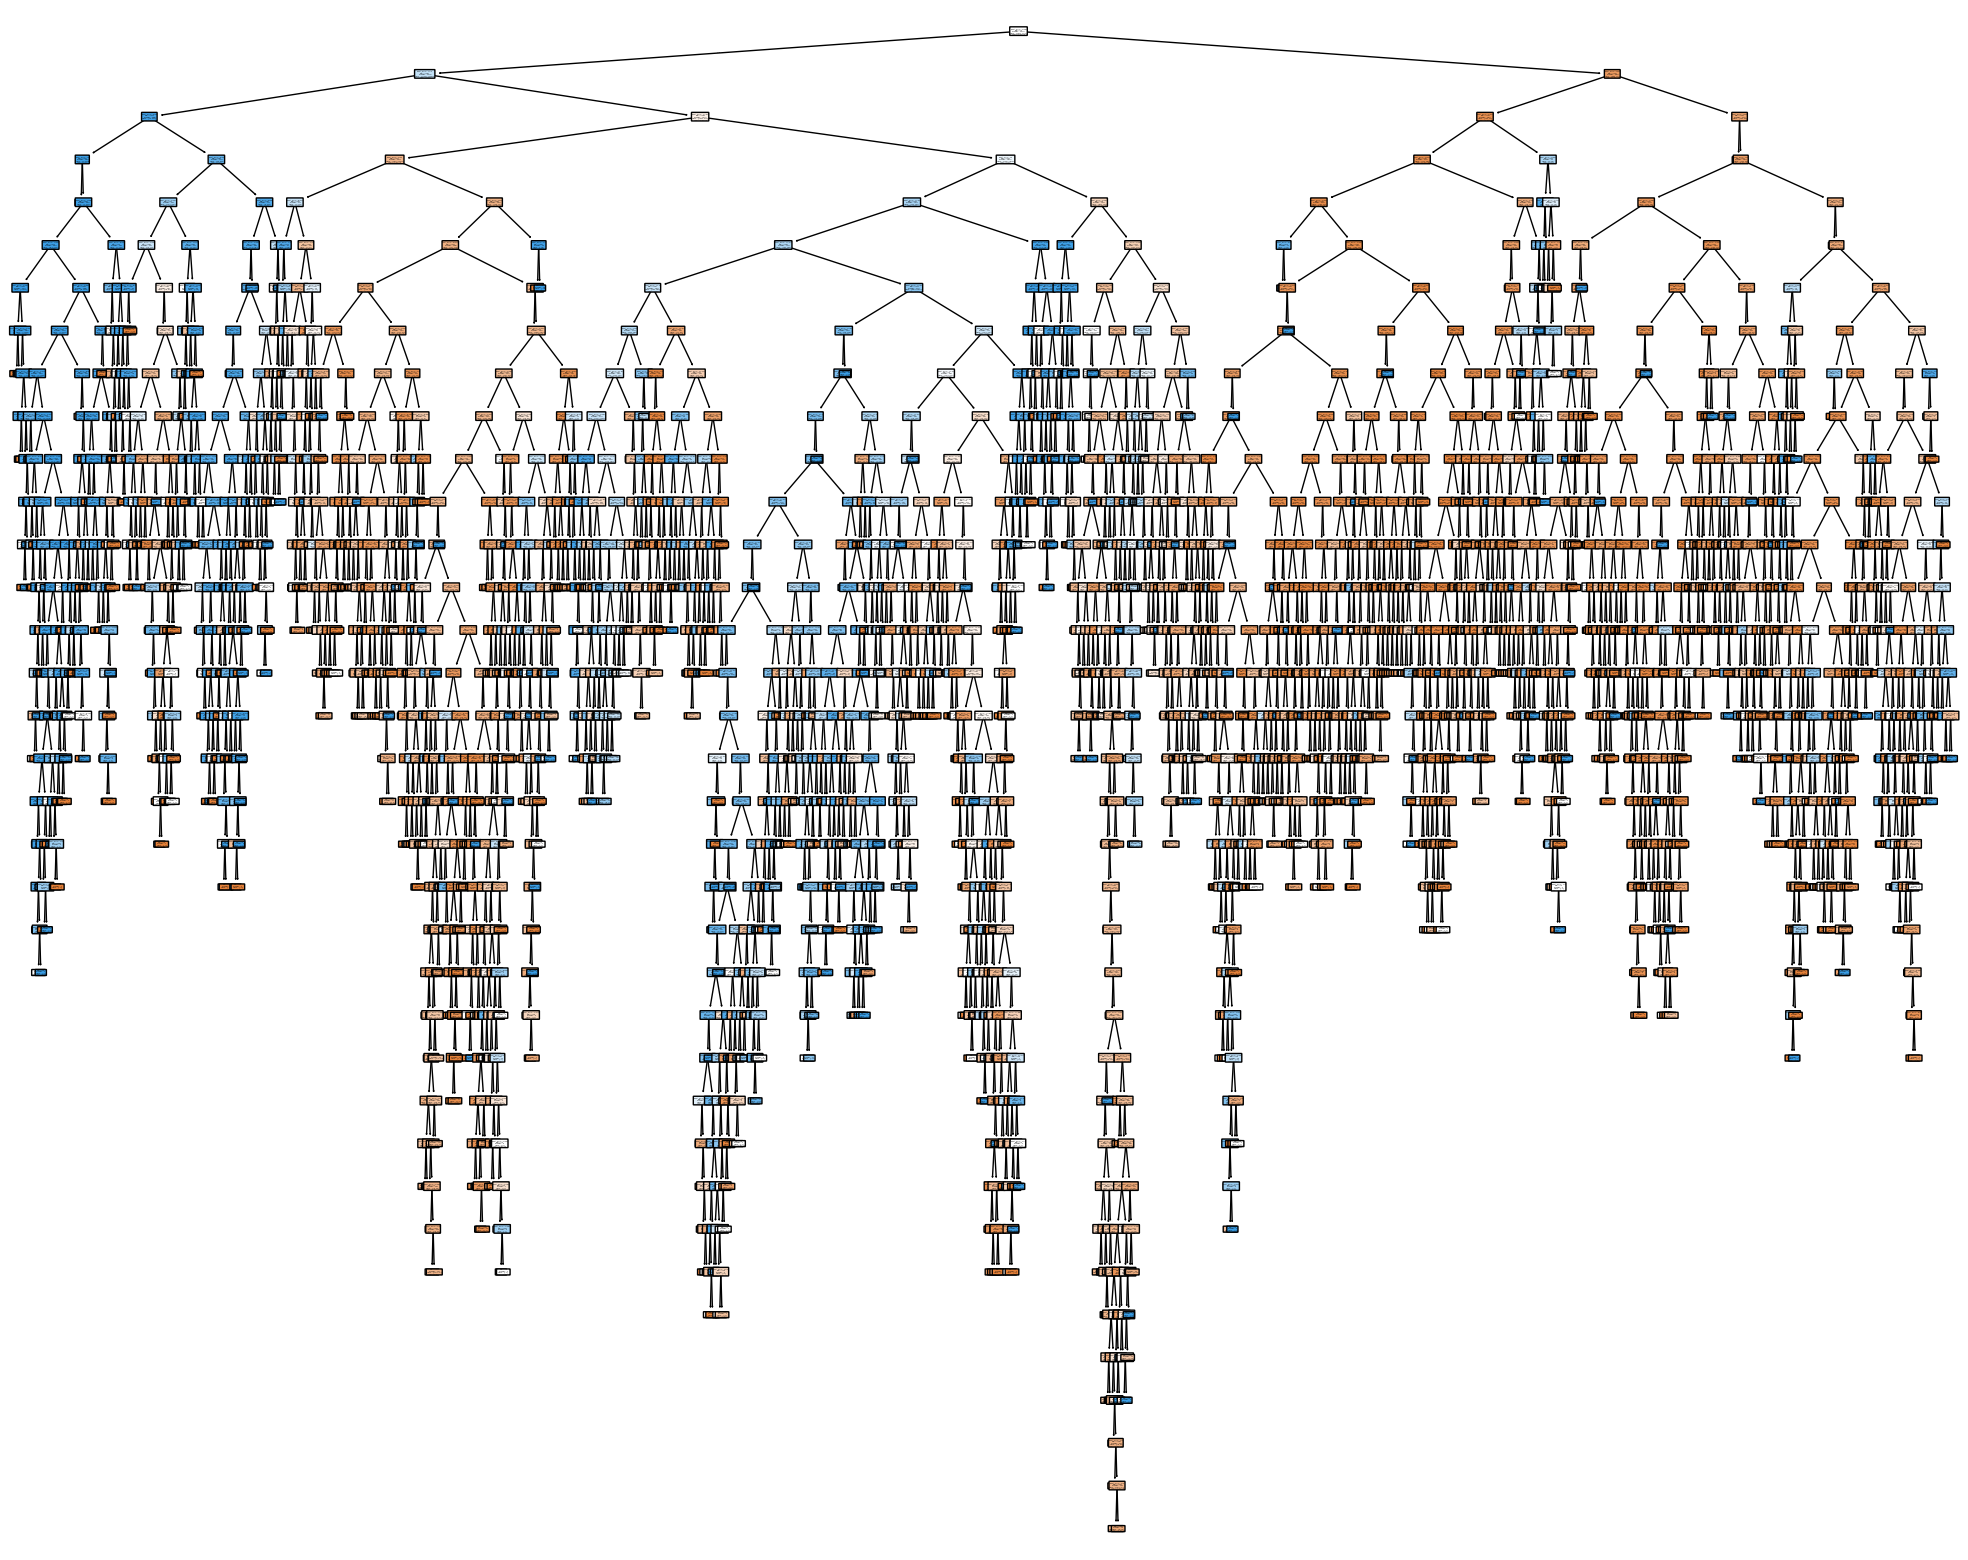

In [ ]:
CT.plot_decision_tree(clf_gini, smart_features, ['No Failure', 'Failure'], save_path="../reports/figures/decision_tree_gini.png")

✅ Decision tree plot saved to ../reports/figures/decision_tree_entropy.png


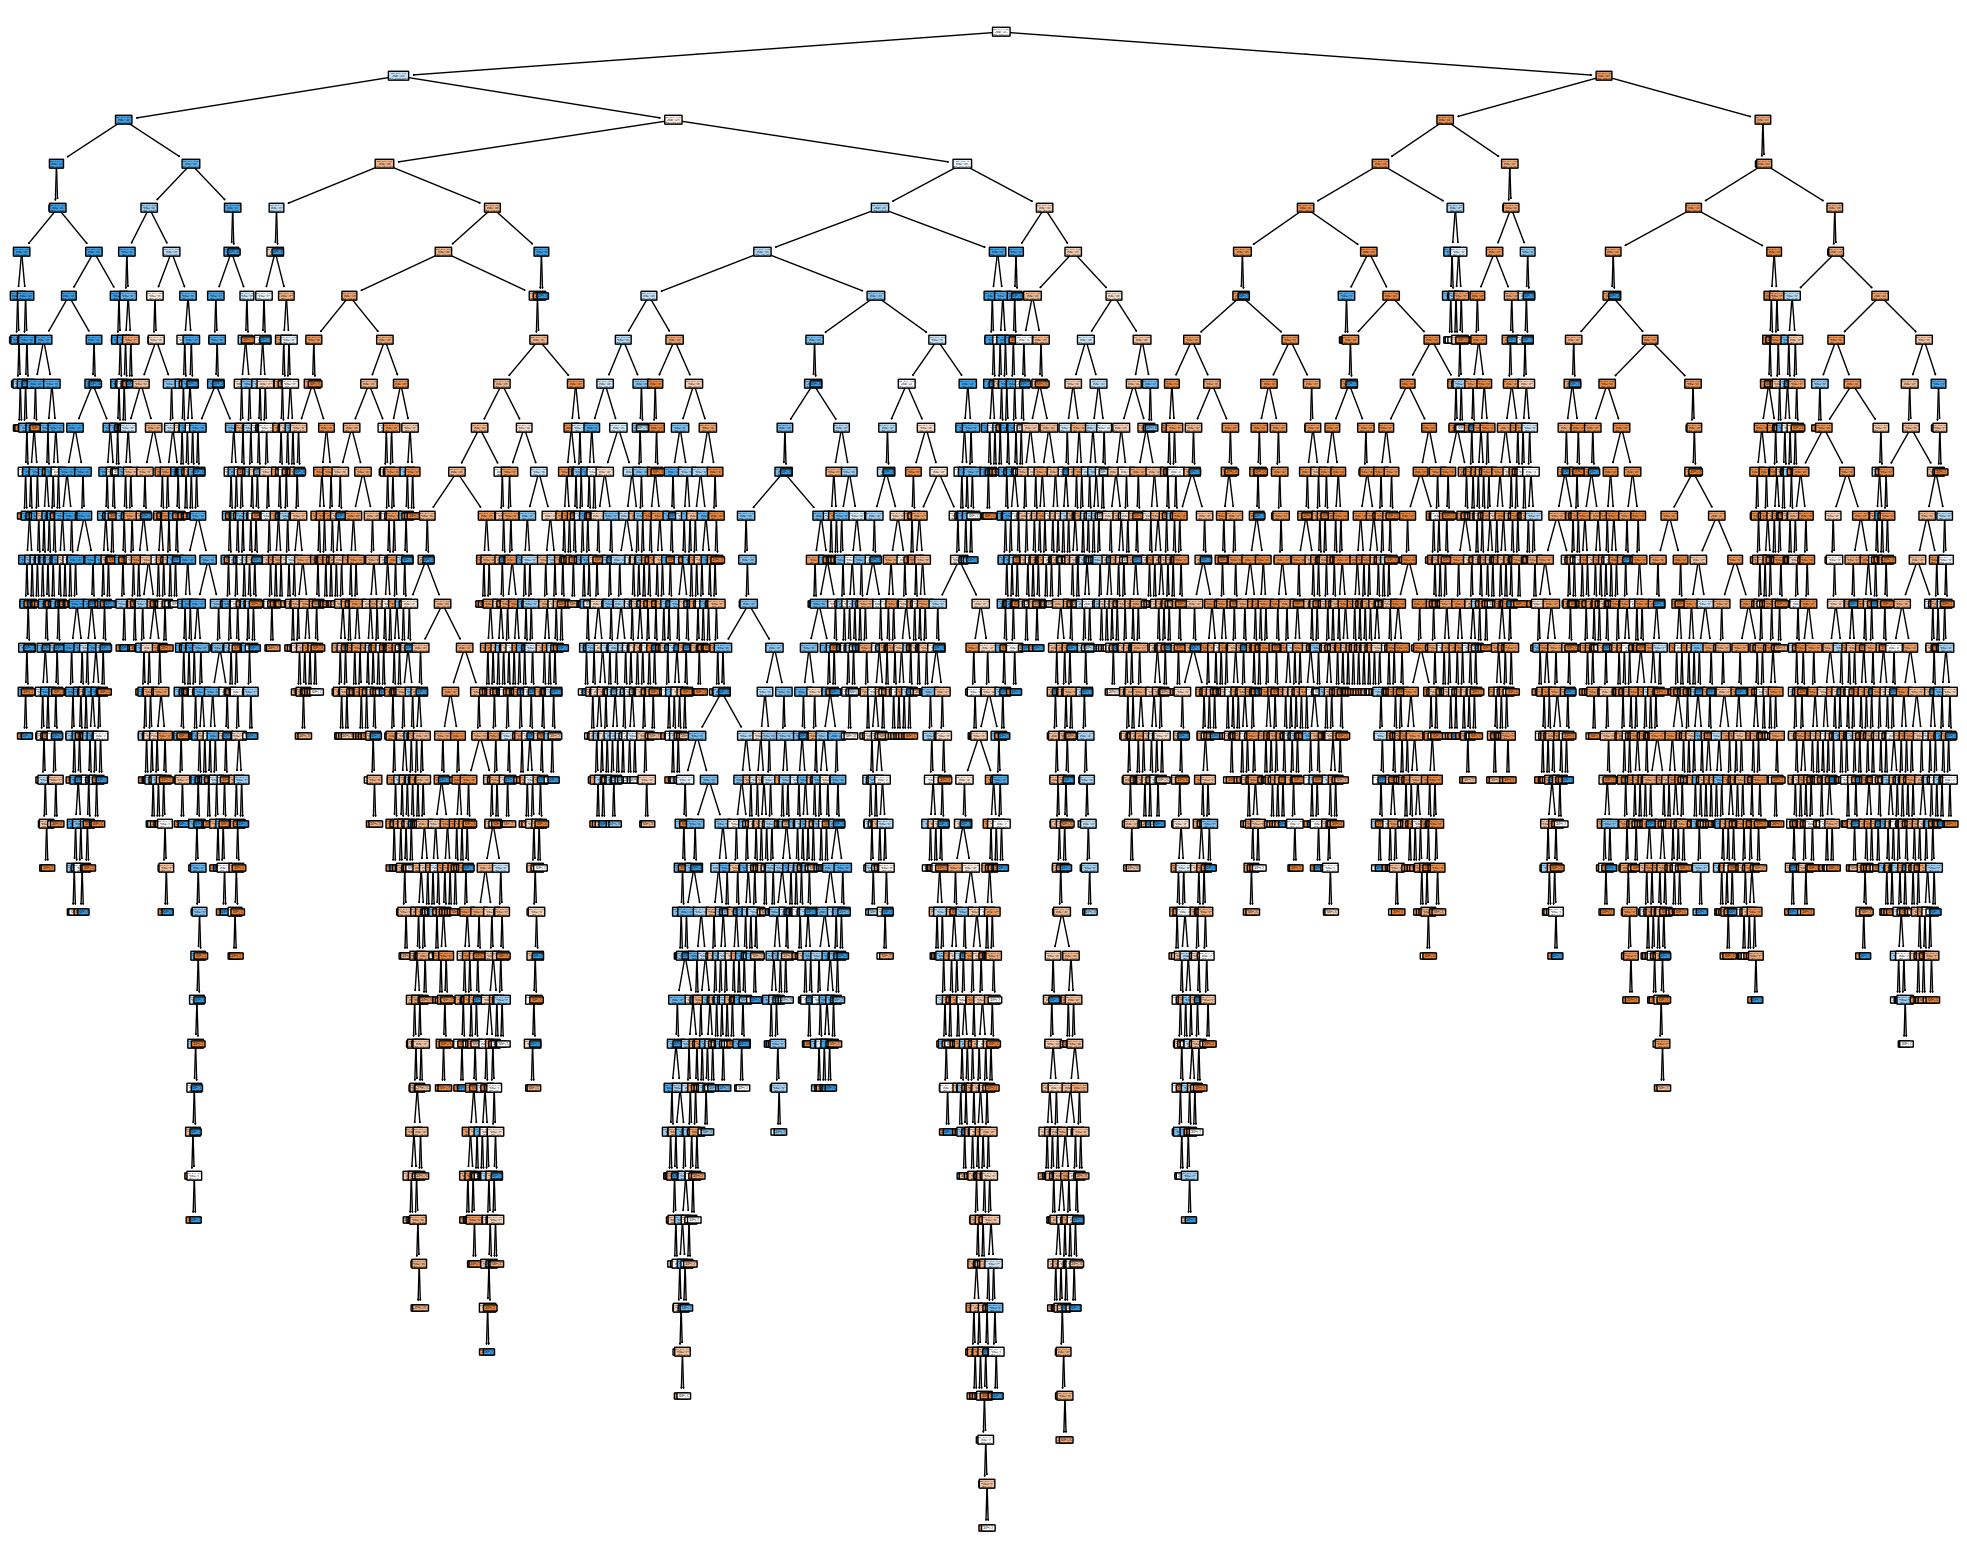

In [ ]:
CT.plot_decision_tree(clf_entropy, smart_features, ['No Failure', 'Failure'], save_path="../reports/figures/decision_tree_entropy.png")

## Pipeline: LSTM + Decision Tree

In [ ]:
path = "../data/validation_data/processed_data/processed_data/"
verbose = True    # Create a single data loader that handles the train/test split properly
model_path = '../models/LSTM/lstm_model.pth'

We load all the data to choose randomly drives to generate predictions from

In [55]:
columns_to_delete = ['model', 'capacity_bytes', 'brand_HGST', 'brand_Hitachi', 'brand_SAMSUNG', 'brand_ST', 'brand_Seagate',
    'brand_TOSHIBA', 'brand_WD', 'brand_WDC', 'brand_WUH',
    'model_freq_Muy Bajo', 'model_freq_Bajo', 'model_freq_Medio',
    'model_freq_Alto', 'model_freq_Muy Alto',
    'Lin_capacity_bytes']

In [70]:
num_drives = 10
data_loader = smart.DriveDataLoader(root=path, 
                                train_ratio=0.01, # we are going to use only the testing data
                                min_sequence_length=min_sequence_length + 1,  # to have 1 day to test  
                                verbose=False, num_drives=num_drives,
                                columns_to_delete=columns_to_delete, normalized_rows=normalized_rows, raw_rows=raw_rows)

Loading CSV files:   0%|          | 0/270 [00:00<?, ?it/s]

Loading CSV files: 100%|██████████| 270/270 [00:04<00:00, 61.96it/s]

[DriveDataLoader] Columns in data: ['date', 'serial_number', 'failure', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_184_normalized', 'smart_187_normalized', 'smart_189_normalized', 'smart_194_normalized', 'smart_195_normalized', 'smart_199_normalized', 'smart_222_normalized']


In [ ]:
selected_drives = data_loader.get_all_data()

print(f"Loaded {len(selected_drives)} days from the dataset from {num_drives} drives.")


Loaded 79 days from the dataset from 10 drives.


In [ ]:
# Extract the last day for each drive and store in a DataFrame
last_days_df = selected_drives.groupby('serial_number').tail(1).reset_index(drop=True)
print(last_days_df)

         date   serial_number  failure  smart_1_normalized  \
0  2022-09-27    45C9K0XTFMYB    False                 100   
1  2022-05-04        5PHLEMXD    False                 100   
2  2022-09-13  PL1331LAGS8TMH    False                 100   
3  2022-09-07        Z302AKSH    False                 111   
4  2022-09-27        Z302SZD7    False                 116   
5  2022-06-08        Z305GXZJ    False                 109   
6  2022-09-27        Z4D066RR    False                 120   
7  2022-03-23        ZHZ4TX1X    False                  82   
8  2022-01-31        ZL23XZS4    False                  77   
9  2022-02-01        ZLW0WJA2    False                  83   

   smart_3_normalized  smart_5_normalized  smart_184_normalized  \
0                 100                 100                     0   
1                 100                 100                     0   
2                 143                 100                     0   
3                  91                 100        

In [ ]:
model_path = '../models/LSTM/lstm_model.pth'
model, model_metrics = smart.load_model(model_path, device, load_whole_model=True)

✅ Complete model loaded from ../models/LSTM/lstm_model.joblib
✅ Model metrics loaded from ../models/LSTM/lstm_model_metrics.json


In [ ]:
model.eval()

Net(
  (lstm): LSTM(10, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=10, bias=True)
)

In [ ]:
ct_feature_list = []
for row in normalized_rows:
    ct_feature_list.append(f'smart_{row}_normalized')
for row in raw_rows:
    ct_feature_list.append(f'smart_{row}_raw')
ct_feature_list += ['serial_number']
predicted_info = pd.DataFrame(columns=ct_feature_list)

predicted_info

,smart_187_normalized,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_195_normalized,smart_199_normalized,smart_194_normalized,smart_184_normalized,smart_189_normalized,smart_222_normalized,serial_number


In [ ]:

for serial, drive_df in tqdm(selected_drives.groupby('serial_number'), desc="Processing drives"):
    # Prepare your input sequence for the LSTM
    features = drive_df.drop(columns=['serial_number', 'date', 'failure']).values
    # Keep only columns from normalized_rows and raw_rows
    cols_to_keep = [f"smart_{i}_normalized" for i in normalized_rows] + [f"smart_{i}_raw" for i in raw_rows]
    features = drive_df[cols_to_keep].values
    # Convert to tensor and add batch/sequence dimensions as needed, and use float64
    input_tensor = torch.tensor(features, dtype=torch.float64).unsqueeze(0)  # shape: [1, seq_len, features]
    # Run through model
    with torch.no_grad():
        prediction = model(input_tensor.to(device))
        last_day_pred = prediction[:, -1, :].cpu().numpy().flatten()
        # Map last_day_pred to ct_feature_list and append to predicted_info
        pred_row = dict(zip(ct_feature_list, last_day_pred))
        pred_row['serial_number'] = serial
        predicted_info = pd.concat([predicted_info, pd.DataFrame([pred_row], columns=predicted_info.columns)], ignore_index=True)

Processing drives:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Green\AppData\Local\Temp\ipykernel_25092\459539953.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_info = pd.concat([predicted_info, pd.DataFrame([pred_row], columns=predicted_info.columns)], ignore_index=True)
Processing drives: 100%|██████████| 10/10 [00:00<00:00, 301.72it/s]


In [ ]:
print(predicted_info)

   smart_187_normalized  smart_1_normalized  smart_3_normalized  \
0             95.859245           87.463840          100.226966   
1             95.859735           87.464265          100.227549   
2             95.859209           87.463780          100.227005   
3             96.034253           87.710879          100.033705   
4             96.034253           87.710879          100.033705   
5             96.034778           87.711355          100.034249   
6             95.859943           87.464559          100.227319   
7             96.034108           87.709410          100.033705   
8             96.034088           87.703738          100.034323   
9             96.034446           87.707251          100.034335   

   smart_5_normalized  smart_195_normalized  smart_199_normalized  \
0          100.213392            100.263084             99.993746   
1          100.213976            100.263684             99.994289   
2          100.213467            100.263168            

In [ ]:
clf_gini = load("../models/DT/best_gini_tree.joblib")
clf_entropy = load("../models/DT/best_entropy_tree.joblib")

In [ ]:
serial_numbers = predicted_info['serial_number'].unique()

In [ ]:
# Only use the feature columns for prediction to avoid warnings
feature_cols = []

# Add normalized columns
for row in normalized_rows:
    feature_cols.append(f'smart_{row}_normalized')

# Add raw columns  
for row in raw_rows:
    feature_cols.append(f'smart_{row}_raw')

print("Formatted feature columns:")
print(feature_cols)


Formatted feature columns:
['smart_187_normalized', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_195_normalized', 'smart_199_normalized', 'smart_194_normalized', 'smart_184_normalized', 'smart_189_normalized', 'smart_222_normalized']


In [ ]:
ct_predictions = CT.prediction(predicted_info[feature_cols].values, clf_gini)

# Add predictions to the DataFrame
predicted_info['CT_Drive_Failed'] = ct_predictions
print(predicted_info)


Predicted values:
[ True  True  True False False False  True False False False]
   smart_187_normalized  smart_1_normalized  smart_3_normalized  \
0             95.859245           87.463840          100.226966   
1             95.859735           87.464265          100.227549   
2             95.859209           87.463780          100.227005   
3             96.034253           87.710879          100.033705   
4             96.034253           87.710879          100.033705   
5             96.034778           87.711355          100.034249   
6             95.859943           87.464559          100.227319   
7             96.034108           87.709410          100.033705   
8             96.034088           87.703738          100.034323   
9             96.034446           87.707251          100.034335   

   smart_5_normalized  smart_195_normalized  smart_199_normalized  \
0          100.213392            100.263084             99.993746   
1          100.213976            100.263684 

### Compare the results of the LSTM and Decision Tree models

In [ ]:

# Compare predicted failure with actual failure for each drive
last_days_df_sorted = last_days_df.set_index('serial_number').loc[serial_numbers].reset_index()
predicted_info['Actual_Failure'] = last_days_df_sorted['failure'].values

# Optionally, print a comparison summary
comparison = predicted_info[['CT_Drive_Failed', 'Actual_Failure']]
print("Prediction vs Actual Failure:\n", comparison)

print("accuracy:", (predicted_info['CT_Drive_Failed'] == predicted_info['Actual_Failure']).mean())



Prediction vs Actual Failure:
    CT_Drive_Failed  Actual_Failure
0             True           False
1             True           False
2             True           False
3            False           False
4            False           False
5            False           False
6             True           False
7            False           False
8            False           False
9            False           False
accuracy: 0.6
